In [1]:
import pandas as pd
import numpy as np
from stratified_dataset import ParallelStratifiedSynthesizer
from snsynth.mst import MSTSynthesizer
from snsynth.aim import AIMSynthesizer
from gem_synthesizer import GEMSynthesizer
import dill
from helpers.data_utils import get_employment, calculate_dimensionality, force_data_categorical_to_numeric
import itertools
import os
from IPython.display import clear_output
from stratified_dataset import StratifiedDataset
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

all_data, features, target, group = get_employment()

def load_pickled_model(filename, torch=False):
    with open(filename, "rb") as file:
        model = dill.load(file)
    return model

df = all_data.copy()

df = df.drop(columns=['CIT', 'MIG', 'DEAR', 'DEYE', 'NATIVITY', 'ANC'])

/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/mbi/__init__.py:15: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn('MixtureInference disabled, please install jax and jaxlib')


['RELP']


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
seed = 1

synthesizers = [MSTSynthesizer, AIMSynthesizer, GEMSynthesizer] #[MSTSynthesizer, AIMSynthesizer] GEMSynthesizer, MSTSynthesizer, 
epsilons = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
omega = 1/12 # (1/k is the default value in the paper)
strata_cols = ['SEX', 'RAC1P']

# Generate all possible combinations of the given column names
combinations = []
for i in range(1, len(strata_cols) + 1):
    combinations.extend(list(itertools.combinations(strata_cols, i)))

In [3]:
def evaluate_on_dataframes(train_df, test_df, target_col = 'ESR'):
    # Feature columns
    feature_cols = [col for col in train_df.columns if col != target_col]

    # Convert all columns to categorical
    for col in train_df.columns:
        train_df[col] = train_df[col].astype('category')

    # Prepare the dataset
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Train the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy
    

# Prepare the real dataset for evaluation
df_numeric = force_data_categorical_to_numeric(df, cat_columns=df.columns)
train, test = train_test_split(df_numeric, test_size=0.2, random_state=42)
accuracy_overall = evaluate_on_dataframes(train, test)

In [ ]:
# get gem_mst where synthesizer contains "MST"

In [16]:
# Read in all results
gem_mst = pd.read_pickle('gem_mst_performance.pkl')
aim = pd.read_pickle('aim_performance.pkl')

# Concat results with proper ordering
all_results = pd.concat([gem_mst[gem_mst.Synthesizer.str.contains("MST")], aim, gem_mst[gem_mst.Synthesizer.str.contains("GEM")]], axis=0)

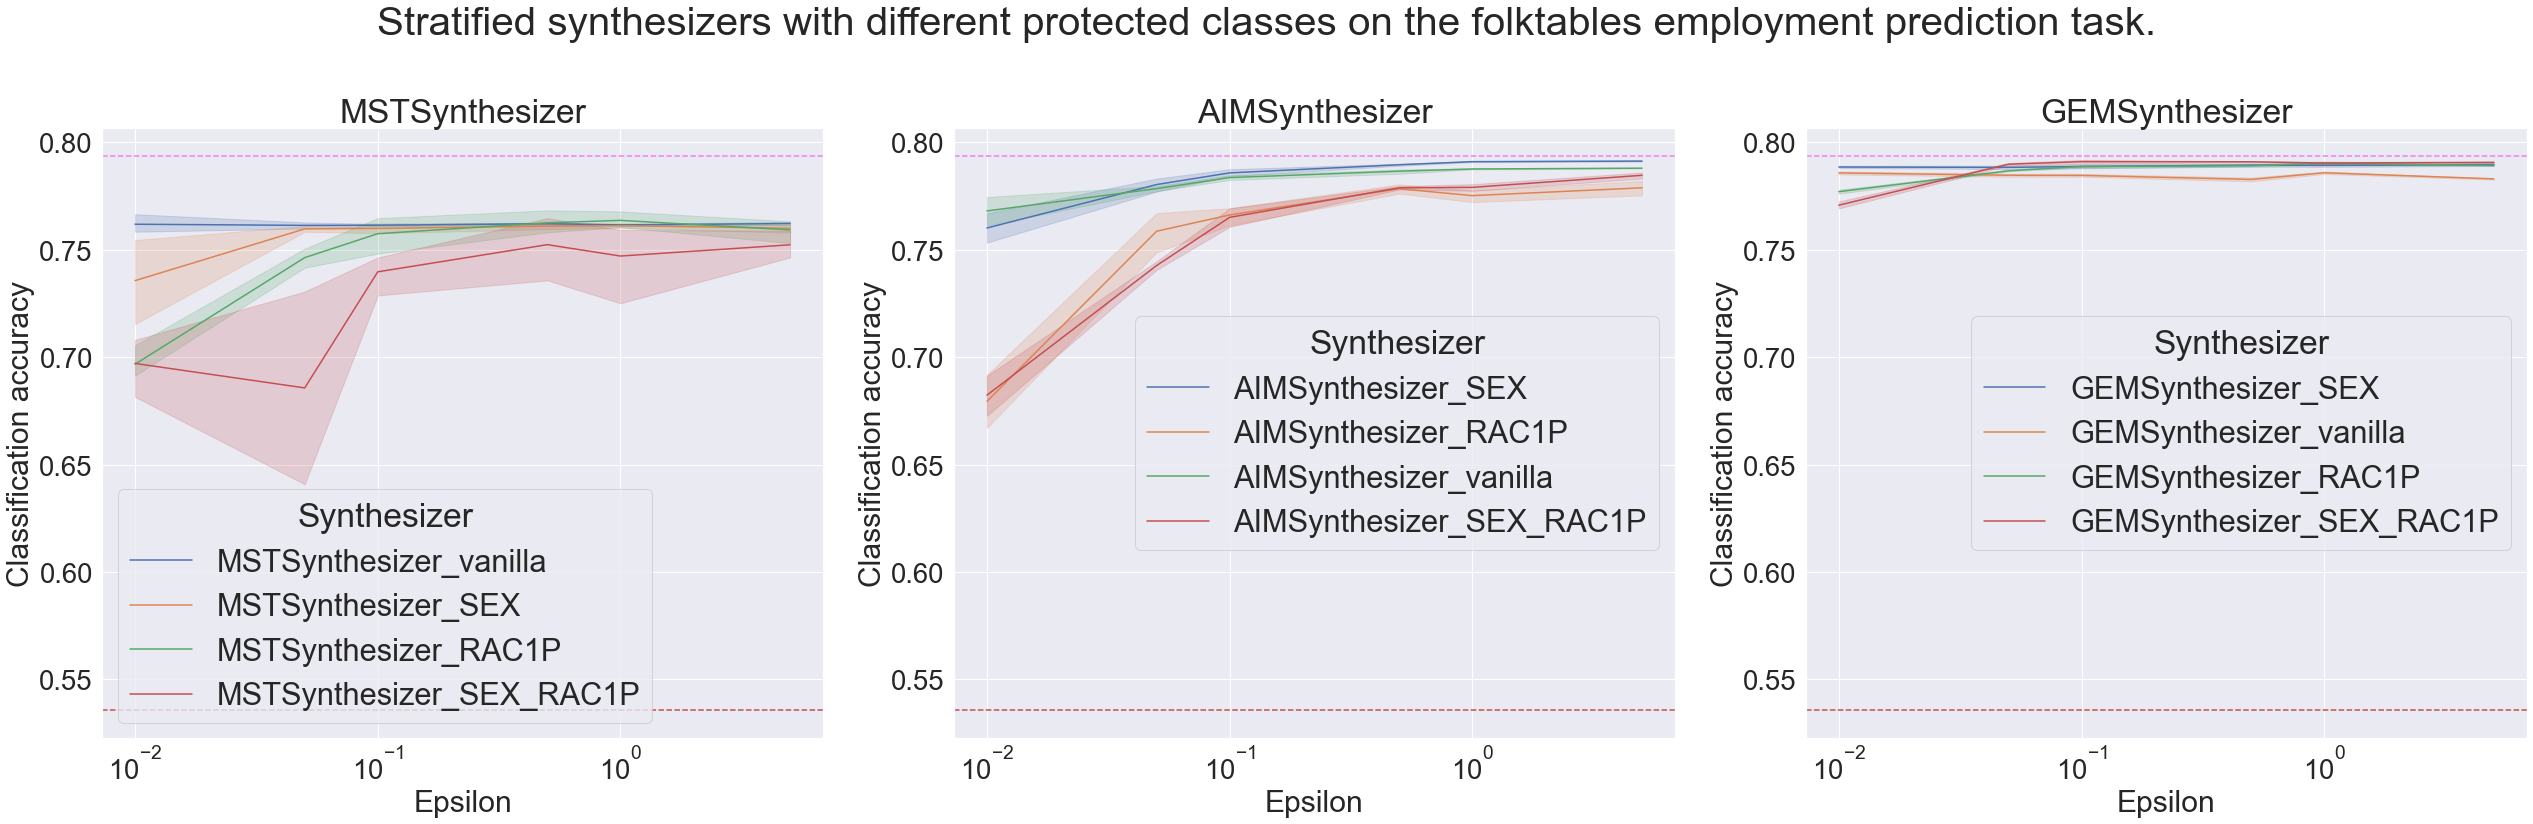

In [87]:
def plot_performance_synths_all_one_plot(performance_df, overall_accuracy):
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set(font_scale=2)
    # add baseline performance horizontal line at specific y value
    baseline = max(df['ESR'].value_counts() / len(df))
    plt.axhline(y=baseline, color='r', linestyle='--')
    plt.axhline(y=overall_accuracy, color='violet', linestyle='--')
    sns.lineplot(data=performance_df, x='Epsilon', y='Accuracy', hue='Synthesizer')
    plt.xlabel("Epsilon")
    plt.ylabel("Classification accuracy")
    plt.title("Stratified synthesizers with different protected classes \n on the employment prediction task.")
    plt.xscale('log')
    plt.show()

def plot_performance_synths_subplots(performance_df, overall_accuracy):
     # Extract unique synthesizer prefixes
    prefixes = performance_df['Synthesizer'].apply(lambda x: x.split('_')[0]).unique()
    
    # Create subplots
    num_prefixes = len(prefixes)
    fig, axes = plt.subplots(nrows=1, ncols=num_prefixes, figsize=(12 * num_prefixes, 12))
    
    sns.set(font_scale=2.8)
    
    for idx, (prefix, ax) in enumerate(zip(prefixes, axes.flatten())):
        filtered_data = performance_df[performance_df['Synthesizer'].str.startswith(prefix)]
        
        # Add baseline performance horizontal line at specific y value
        baseline = max(df['ESR'].value_counts() / len(df))
        ax.axhline(y=baseline, color='r', linestyle='--')
        ax.axhline(y=overall_accuracy, color='violet', linestyle='--')
        sns.lineplot(data=filtered_data, x='Epsilon', y='Accuracy', hue='Synthesizer', ax=ax)
        ax.set_xlabel("Epsilon")
        ax.set_ylabel("Classification accuracy")
        ax.set_title(f"{prefix}")
        ax.set_xscale('log')
    # set plt overall title
    plt.suptitle(f"Stratified synthesizers with different protected classes on the folktables employment prediction task.")
    plt.tight_layout()
    plt.show()

# load performance_df
plot_performance_synths_subplots(all_results, overall_accuracy=accuracy_overall)

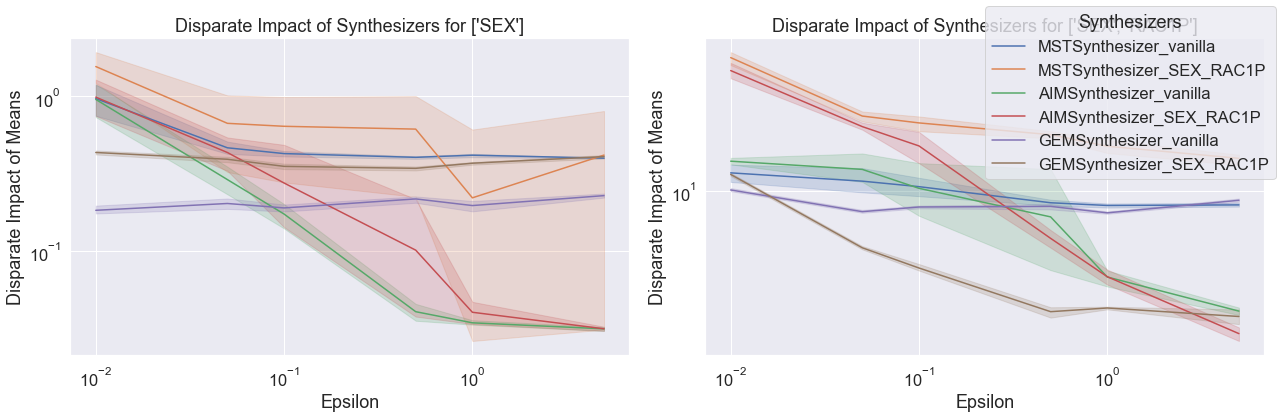

In [37]:
def plot_disparate_impact_subplots_strata_only_limited(performance_df, function_name, di_type="_parity_error"):
    intersectional_groups = ["['SEX']", "['SEX', 'RAC1P']"]
    synth_filters = {
        "['SEX']": ['MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX',
                    'AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX',
                    'GEMSynthesizer_vanilla', 'GEMSynthesizer_SEX'],
        "['SEX', 'RAC1P']": ['MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX_RAC1P',
                            'AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX_RAC1P',
                            'GEMSynthesizer_vanilla', 'GEMSynthesizer_SEX_RAC1P'],
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        relevant_synths = synth_filters[group]
        filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]
        
        data = filtered_data[['Synthesizer', 'Epsilon', group+di_type]]
        data = data.rename(columns={group+di_type: 'Disparate Impact'})
        data.reset_index(inplace=True)
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()
plot_disparate_impact_subplots_strata_only_limited(all_results, function_name='Means')

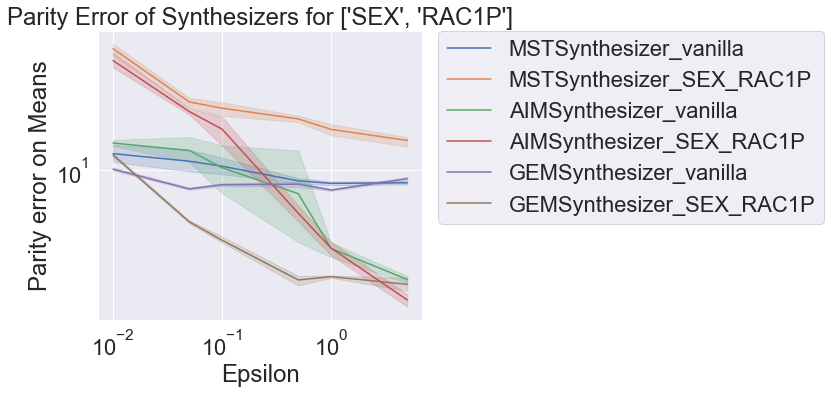

In [77]:
def plot_disparate_impact_subplots_strata_only_limited(performance_df, function_name, di_type="_parity_error"):
    intersectional_group = "['SEX', 'RAC1P']"
    synth_filter = ['MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX_RAC1P',
                    'AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX_RAC1P',
                    'GEMSynthesizer_vanilla', 'GEMSynthesizer_SEX_RAC1P']

    fig, ax = plt.subplots(figsize=(12, 6))
    
    relevant_synths = synth_filter
    filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]

    data = filtered_data[['Synthesizer', 'Epsilon', intersectional_group+di_type]]
    data = data.rename(columns={intersectional_group+di_type: 'Parity Error'})
    data.reset_index(inplace=True)
    data['Intersectional Group'] = intersectional_group
    data['Parity Error'] = data['Parity Error'].apply(lambda x: sum(x[~np.isnan(x)]))
    sns.set(font_scale=2)
    sns.lineplot(x='Epsilon', y='Parity Error', hue='Synthesizer', data=data, ax=ax)
    ax.set_title(f"Parity Error of Synthesizers for {intersectional_group}")
    ax.set_xlabel('Epsilon')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Parity error on ' + function_name)
    ax.legend(title='Synthesizers')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

plot_disparate_impact_subplots_strata_only_limited(all_results, function_name='Means')

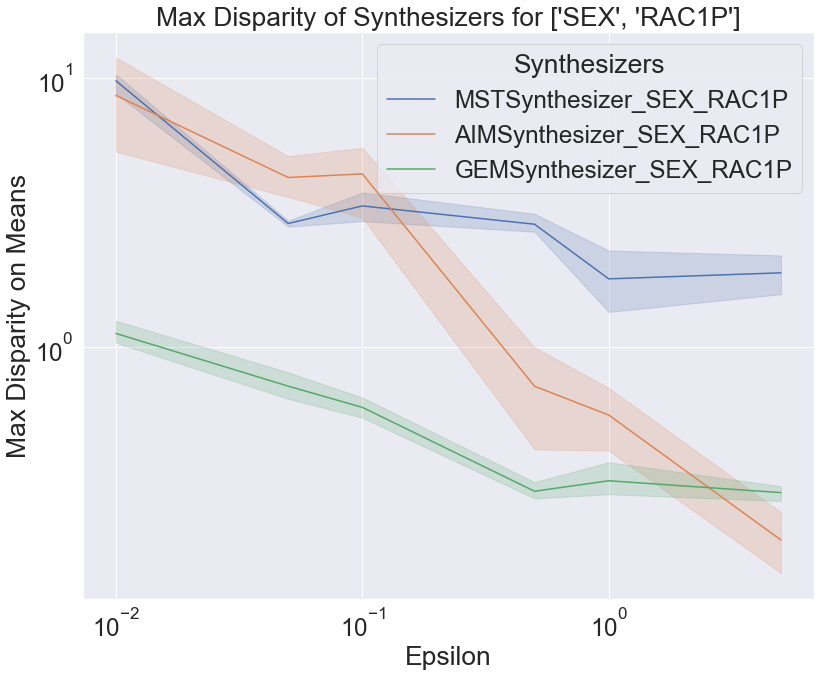

In [73]:
def plot_max_disparity_subplots_strata_only_limited(performance_df, function_name, di_type="_max_disparity"):
    intersectional_group = "['SEX', 'RAC1P']"
    synth_filter = ['MSTSynthesizer_SEX_RAC1P',
                    'AIMSynthesizer_SEX_RAC1P',
                    'GEMSynthesizer_SEX_RAC1P']

    fig, ax = plt.subplots(figsize=(12, 10))
    
    relevant_synths = synth_filter
    filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]

    data = filtered_data[['Synthesizer', 'Epsilon', intersectional_group+di_type]]
    data = data.rename(columns={intersectional_group+di_type: 'Max Disparity'})
    data.reset_index(inplace=True)
    data['Intersectional Group'] = intersectional_group
    data['Max Disparity'] = data['Max Disparity'].apply(lambda x: x[0])
    sns.set(font_scale=2.2)
    sns.lineplot(x='Epsilon', y='Max Disparity', hue='Synthesizer', data=data, ax=ax)
    ax.set_title(f"Max Disparity of Synthesizers for {intersectional_group}")
    ax.set_xlabel('Epsilon')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Max Disparity on ' + function_name)
    ax.legend(title='Synthesizers')
    
    plt.tight_layout()
    plt.show()

plot_max_disparity_subplots_strata_only_limited(all_results, function_name='Means')

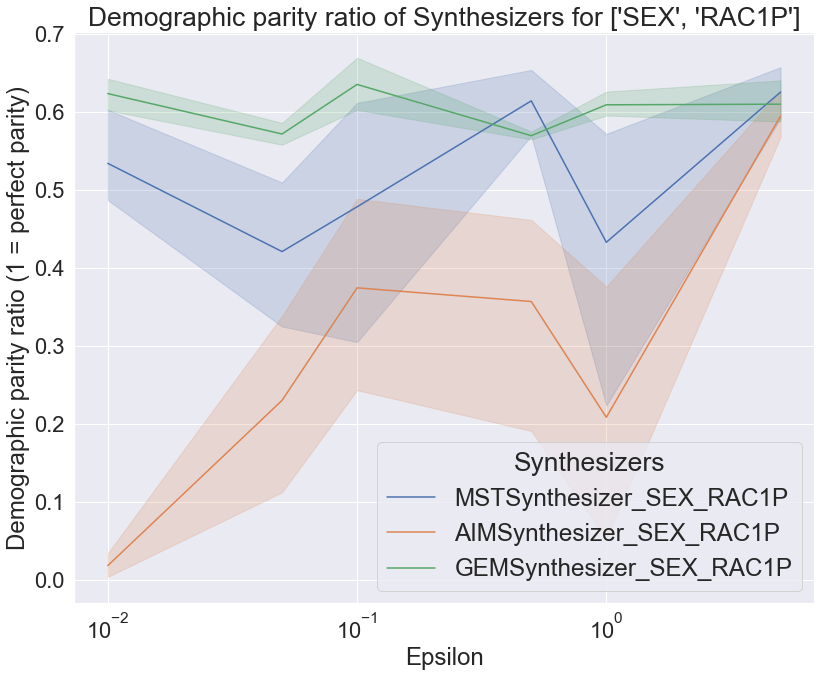

In [71]:
def plot_dem_par_subplots_strata_only_limited(performance_df, function_name, di_type="_max_disparity"):
    intersectional_group = "['SEX', 'RAC1P']"
    synth_filter = ['MSTSynthesizer_SEX_RAC1P',
                    'AIMSynthesizer_SEX_RAC1P',
                    'GEMSynthesizer_SEX_RAC1P']

    fig, ax = plt.subplots(figsize=(12, 10))
    
    relevant_synths = synth_filter
    filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]

    data = filtered_data[['Synthesizer', 'Epsilon', 'Demographic_parity_ratio']]
    data = data.rename(columns={'Demographic_parity_ratio': 'Demographic parity ratio'})
    data.reset_index(inplace=True)
    data['Intersectional Group'] = intersectional_group
    sns.set(font_scale=2.2)
    sns.lineplot(x='Epsilon', y='Demographic parity ratio', hue='Synthesizer', data=data, ax=ax)
    ax.set_title(f"Demographic parity ratio of Synthesizers for {intersectional_group}")
    ax.set_xlabel('Epsilon')
    ax.set_xscale('log')
    ax.set_ylabel('Demographic parity ratio (1 = perfect parity)')
    ax.legend(title='Synthesizers')
    
    plt.tight_layout()
    plt.show()

plot_dem_par_subplots_strata_only_limited(all_results, function_name='Means')

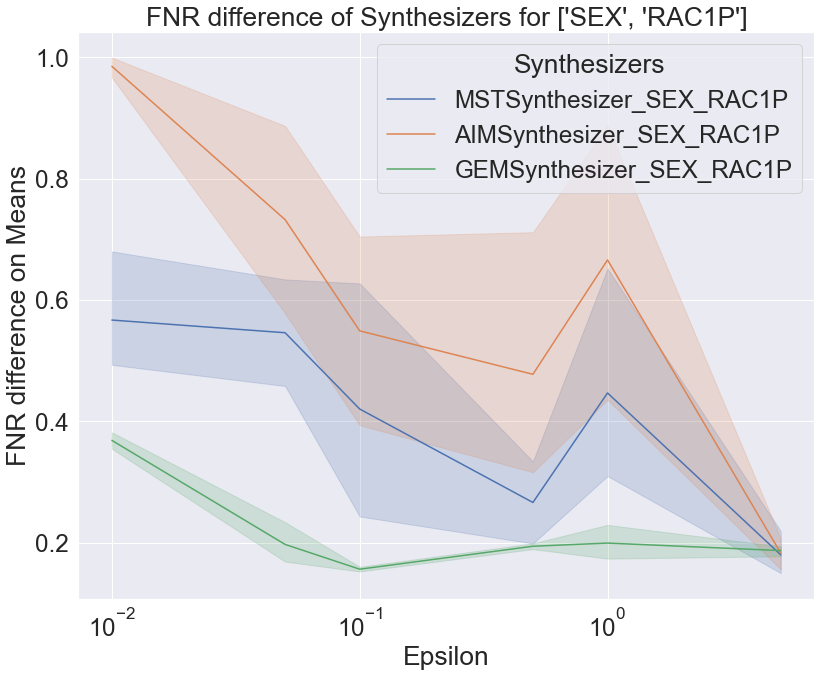

In [72]:
def plot_dem_par_subplots_strata_only_limited(performance_df, function_name, di_type="_max_disparity"):
    intersectional_group = "['SEX', 'RAC1P']"
    synth_filter = ['MSTSynthesizer_SEX_RAC1P',
                    'AIMSynthesizer_SEX_RAC1P',
                    'GEMSynthesizer_SEX_RAC1P']

    fig, ax = plt.subplots(figsize=(12, 10))
    
    relevant_synths = synth_filter
    filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]

    data = filtered_data[['Synthesizer', 'Epsilon', 'FNR_difference']]
    data = data.rename(columns={'FNR_difference': 'FNR difference'})
    data.reset_index(inplace=True)
    data['Intersectional Group'] = intersectional_group
    sns.set(font_scale=2.2)
    sns.lineplot(x='Epsilon', y='FNR difference', hue='Synthesizer', data=data, ax=ax)
    ax.set_title(f"FNR difference of Synthesizers for {intersectional_group}")
    ax.set_xlabel('Epsilon')
    ax.set_xscale('log')
    ax.set_ylabel('FNR difference on ' + function_name)
    ax.legend(title='Synthesizers')
    
    plt.tight_layout()
    plt.show()

plot_dem_par_subplots_strata_only_limited(all_results, function_name='Means')

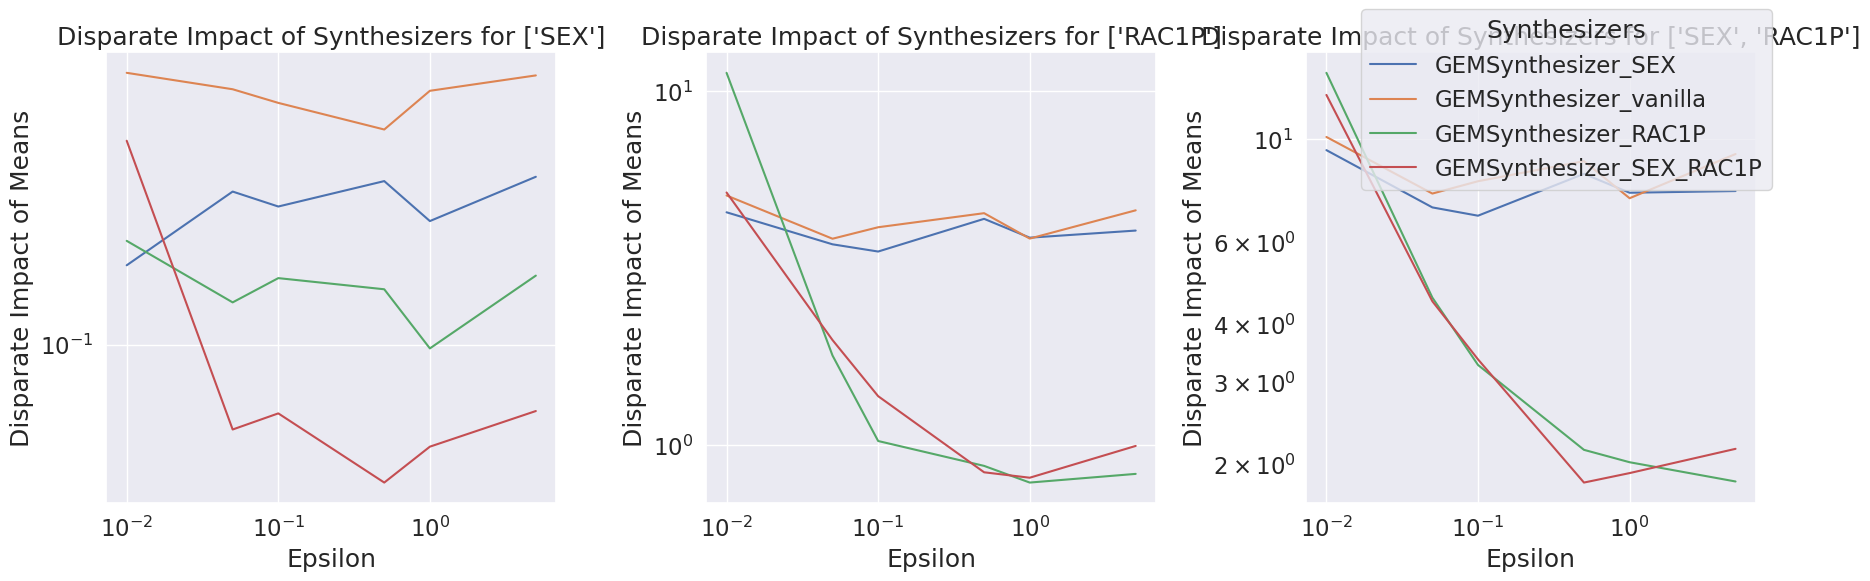

In [83]:
def plot_disparate_impact_subplots(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['RAC1P']", "['SEX', 'RAC1P']"]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        data = performance_df[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        sns.set(font_scale=2)
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()

# Call the function with your performance_df
plot_disparate_impact_subplots(performance_df, function_name='Means')
# 